<a href="https://colab.research.google.com/github/surajn28/NMA-Transfer_Learning/blob/main/Transfer_learning_FER_ResNet_32_0_01lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
os.chdir('/content/drive/MyDrive/NMA/NMA-Transfer_Learning')
print(os.getcwd())
print(os.listdir())

/content/drive/MyDrive/NMA/NMA-Transfer_Learning
['.git', 'README.md', 'ResNet.py', 'Tansfer_Learning.ipynb', 'Transfer_learning_FER_ResNet.ipynb', 'data_collect.py', 'data_loader.py', 'load_vgg11_demo.ipynb', 'prepare_files', 'test.txt', 'train.py', '__pycache__', 'results', 'checkpoint']


In [3]:
# imports
import os
import gc
import csv
import glob
import torch
import pandas as pd
import PIL
import h5py
import multiprocessing

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from google.colab import drive
from ResNet import ResNet,BasicBlock,Bottleneck

Batch size: torch.Size([50, 3, 762, 562])


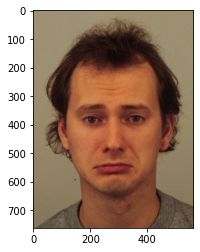

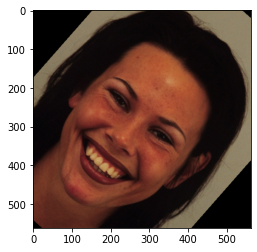

In [4]:
# Data loader with data augmentation

class H5FileDataset(Dataset):
    # dataloader output: (pic_indices, color_channel, height, width)

    def __init__(self, h5_filename, transform=None, target_transform=None):
        self.h5_filename = h5_filename
        self.img_h5_file = self._load_h5_file(self.h5_filename)
        self.all_labels = self.img_h5_file['labels'][:]


    def __len__(self):
        return len(self.all_labels)


    def __getitem__(self, idx):
        img = self.img_h5_file['img_data'][idx]
        label = self.img_h5_file['labels'][idx]
        # sample = {'data': img,
        #           'label': label,
        #           'img_idx': idx}
        # img = img.transform([2, 0, 1])
        img = np.transpose(img, [2, 0, 1])
        img = img.astype(np.double)
        return img, label


    def _load_h5_file(self, h5_filename):
        file = h5py.File(h5_filename, 'r')
        img_data = file['pic_mat']
        img_labels = file['labels']
        # img_data.transpose((2, 0, 1))
        return dict(file=file, img_data=img_data, labels=img_labels)

kdef_test_dataset = H5FileDataset('../../datasets/KDEF_h5/kdef_test_dataset.h5')
test_dataloader = torch.utils.data.DataLoader(kdef_test_dataset, batch_size=50, shuffle=True)
batch_images, batch_labels = next(iter(test_dataloader))
print('Batch size:', batch_images.shape)
plt.figure()
plt.imshow(batch_images[0].to(torch.uint8).permute([1, 2, 0]).to(torch.uint8))
plt.show()

# transform_list = [transforms.RandomRotation(10)]
transform_list = [transforms.RandomRotation(90), transforms.CenterCrop([562, 562])]
aug = transforms.Compose(transform_list)

# aug = transforms.CenterCrop([64, 64])
for x, y in test_dataloader:
    # x = x.permute([0, 3, 1, 2])  # x: (idx, color_channel, height, width)
    x_aug = aug(x)
plt.imshow(x_aug[0].permute([1, 2, 0]).to(torch.uint8))

In [5]:
from ResNet import ResNet,BasicBlock,Bottleneck
def ResNet18():
  return ResNet(BasicBlock, [2, 2, 2, 2])

# hyper-parameters
use_cuda = torch.cuda.is_available()
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
batch_size = 32
max_epochs = 15  # Please change this to 200
max_epochs_target = 10
base_learning_rate = 0.01
torchvision_transforms = True  # True/False if you want use torchvision augmentations

def train(net, epoch, trainloader, use_cuda=True):
  print('\nEpoch: %d' % epoch)
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
    print('batch_idx ', batch_idx)
    targets = np.array(targets, dtype=str)
    targets_num = np.zeros(len(targets))
    # print(targets_num.shape)
    for idx_target in range(len(targets)):
      if targets[idx_target] == 'joy':
        targets_num[idx_target] = 0
      else:
        targets_num[idx_target] = 1
    targets = torch.as_tensor(targets_num, dtype=torch.long)
    if use_cuda:
      inputs, targets = inputs.cuda(), targets.cuda()
    

    optimizer.zero_grad()
    inputs, targets = Variable(inputs), Variable(targets)
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    print('optimizer ', batch_idx)

    train_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += predicted.eq(targets.data).cpu().sum()
    print('correct ', batch_idx)

    # if batch_idx % 500 == 0:
    print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      
  return (train_loss/batch_idx, 100.*correct/total)


def test(net, epoch, testloader, outModelName, use_cuda=True):
  global best_acc
  net.eval()
  test_loss, correct, total = 0, 0, 0
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
      print('batch_idx ', batch_idx)
      targets = np.array(targets, dtype=str)
      targets_num = np.zeros(len(targets))
      # print(targets_num.shape)
      for idx_target in range(len(targets)):
        if targets[idx_target] == 'joy':
          targets_num[idx_target] = 0
        else:
          targets_num[idx_target] = 1
      targets = torch.as_tensor(targets_num, dtype=torch.long)
      print('converted targets', batch_idx)
      if use_cuda:
        inputs, targets = inputs.cuda(), targets.cuda()

      outputs = net(inputs)
      loss = criterion(outputs, targets)

      test_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      if batch_idx % 200 == 0:
        print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(net, acc, epoch, outModelName)
    return (test_loss/batch_idx, 100.*correct/total)

# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir('checkpoint'):
      os.mkdir('checkpoint')
  torch.save(state, f'./checkpoint/{outModelName}.t7')

def adjust_learning_rate(optimizer, epoch):
  """decrease the learning rate at 100 and 150 epoch"""
  lr = base_learning_rate
  if epoch <= 9 and lr > 0.1:
    # warm-up training for large minibatch
    lr = 0.1 + (base_learning_rate - 0.1) * epoch / 10.
  if epoch >= 100:
    lr /= 10
  if epoch >= 150:
    lr /= 10
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr

# if __name__=="__main__":

In [6]:
path = '../../datasets/FERG_h5'
trainset = H5FileDataset(os.path.join(path,'train_dataset.h5'))
testset = H5FileDataset(os.path.join(path,'test_dataset.h5'))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=12, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=12, shuffle=True)

In [ ]:
net = ResNet18()
net = net.double()
net = net.cuda()
result_folder = './results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

logname = result_folder + net.__class__.__name__ + '_pretrain' + '.csv'

# Optimizer and criterion
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=base_learning_rate, momentum=0.9, weight_decay=1e-4)

outModelName = 'pretrain'
if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'train acc', 'test loss', 'test acc'])

for epoch in range(start_epoch, max_epochs):
    adjust_learning_rate(optimizer, epoch)
    print('finished adjust lr')
    train_loss, train_acc = train(net, epoch, trainloader, use_cuda=use_cuda)
    print('finished train epoch ', epoch)
    test_loss, test_acc = test(net, epoch, testloader, outModelName, use_cuda=use_cuda)
    print('finished test epoch ', epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, train_acc.item(), test_loss, test_acc.item()])
    print(f'Epoch: {epoch} | train acc: {train_acc} | test acc: {test_acc}')

Streaming output truncated to the last 5000 lines.
converted targets 26
batch_idx  27
converted targets 27
batch_idx  28
converted targets 28
batch_idx  29
converted targets 29
batch_idx  30
converted targets 30
batch_idx  31
converted targets 31
batch_idx  32
converted targets 32
batch_idx  33
converted targets 33
batch_idx  34
converted targets 34
batch_idx  35
converted targets 35
batch_idx  36
converted targets 36
batch_idx  37
converted targets 37
batch_idx  38
converted targets 38
batch_idx  39
converted targets 39
batch_idx  40
converted targets 40
batch_idx  41
converted targets 41
batch_idx  42
converted targets 42
batch_idx  43
converted targets 43
batch_idx  44
converted targets 44
batch_idx  45
converted targets 45
batch_idx  46
converted targets 46
batch_idx  47
converted targets 47
batch_idx  48
converted targets 48
batch_idx  49
converted targets 49
batch_idx  50
converted targets 50
batch_idx  51
converted targets 51
batch_idx  52
converted targets 52
batch_idx  53
conv